# ARCH/GARCH Volatility Forecasting

The development of a volatility model for an asset-return series consists of four steps:
1. Build an ARMA time series model for the financial time series based on the serial dependence revealed by the ACF and PACF.
2. Test the residuals of the model for ARCH/GARCH effects, again relying on the ACF and PACF for the series of the squared residual.
3. Specify a volatility model if serial correlation effects are significant, and jointly estimate the mean and volatility equations.
4. Check the fitted model carefully and refine it if necessary

When applying volatility forecasting to return series, the serial dependence may be limited so that a constant mean may be used instead of an ARMA model.

The `arch` library provides several options to estimate volatility-forecasting models. It offers several options to model the expected mean, including a constant mean, the AR(p) model discussed in the section on univariate time series models above as well as more recent heterogeneous autoregressive processes (HAR) that use daily (1 day), weekly (5 days), and monthly (22 days) lags to capture the trading frequencies of short-, medium-, and long-term investors.

The mean models can be jointly defined and estimated with several conditional heteroskedasticity models that include, in addition to ARCH and GARCH, the exponential GARCH (EGARCH) model, which allows for asymmetric effects between positive and negative returns and the heterogeneous ARCH (HARCH) model, which complements the HAR mean model.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

## Correlogram Plot

In [7]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True)
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download NASDAQ Index Data

We will use daily NASDAQ returns from 1998-2017 to demonstrate the usage of a GARCH model

In [5]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) # rescale to faciliate optimization

## Explore Returns and Volatility

The rescaled daily return series exhibits only limited autocorrelation, but the squared deviations from the mean do have substantial memory reflected in the slowly-decaying ACF and the PACF high for the first two and cutting off only after the first six lags:

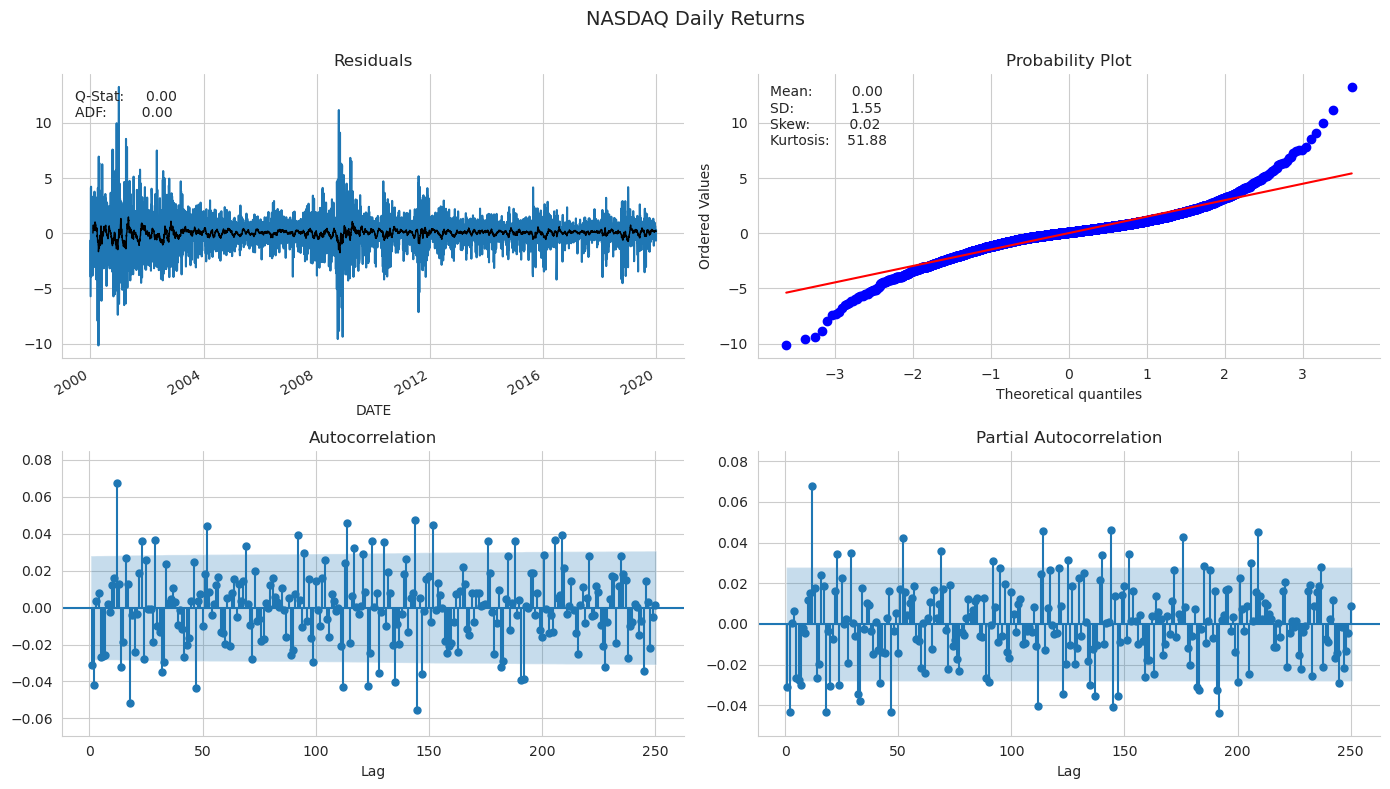

In [8]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

The function plot_correlogram produces the following output:

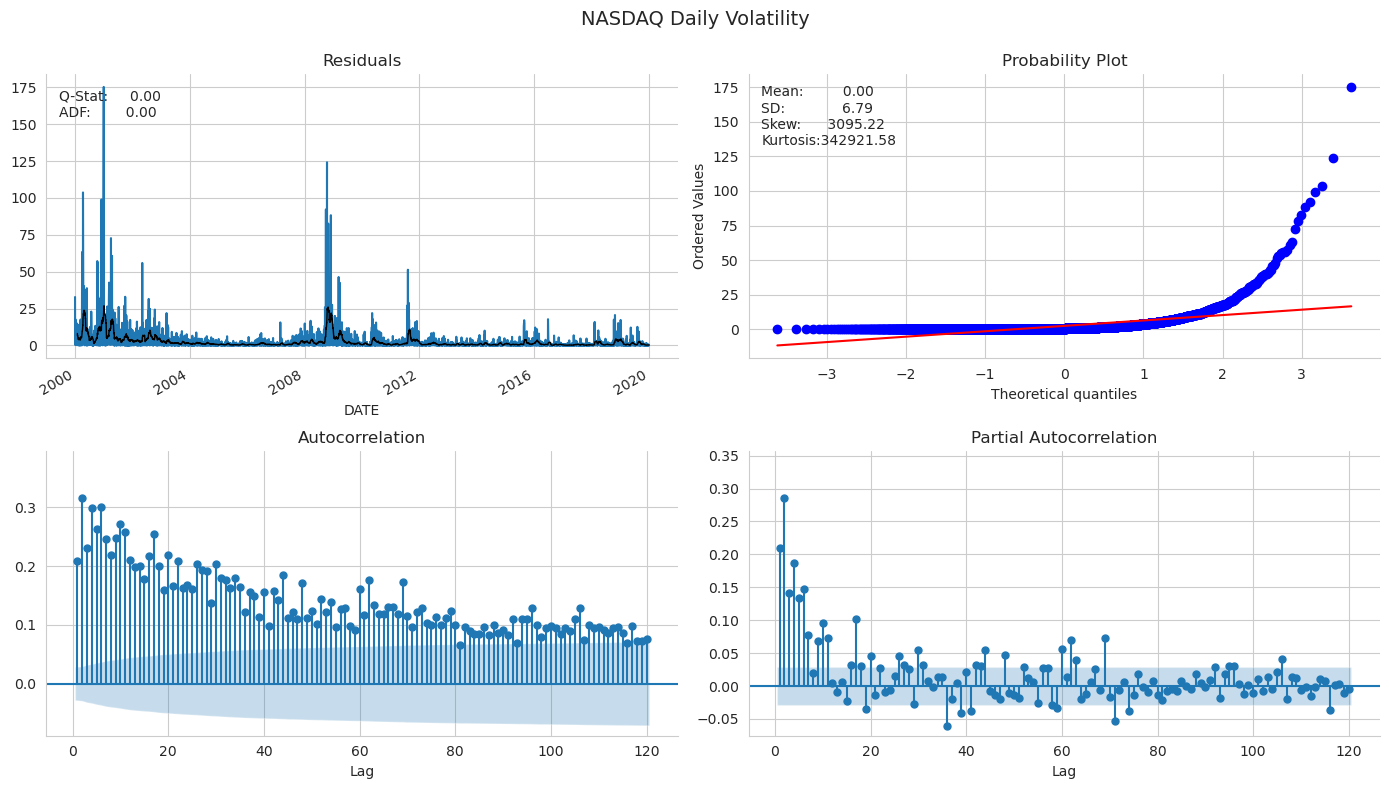

In [9]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

## Model Selection: rolling out-of-sample forecasts

Hence, we can estimate a GARCH model to capture the linear relationship of past volatilities. We will use rolling 10-year windows to estimate a GARCH(p, q) model with p and q ranging from 1-4 to generate 1-step out-of-sample forecasts. 

We then compare the RMSE of the predicted volatility relative to the actual squared deviation of the return from its mean to identify the most predictive model. We are using winsorized data to limit the impact of extreme return values reflected in the very high positive skew of the volatility

In [10]:
trainsize = 10 * 252  # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                           upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [11]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

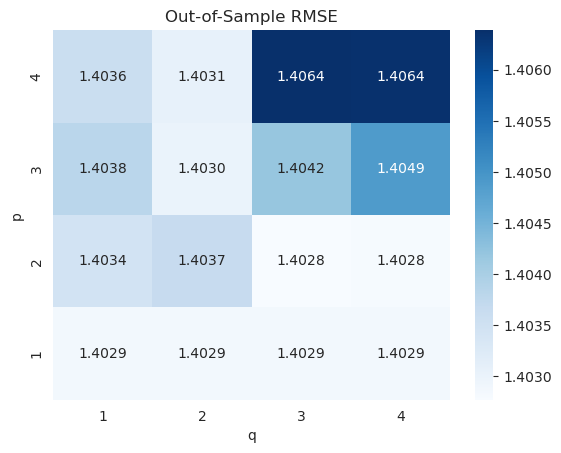

In [12]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

## Estimate GARCH(2, 2) Model

The GARCH(2, 2) model achieves the second-lowest RMSE but has fewer parameters than the slightly better-performing GARCH(2, 4), so we go ahead and estimate this model to inspect the summary.

The output shows the maximized log-likelihood as well as the AIC and BIC criteria that are commonly minimized when selecting models based on in-sample performance (see Chapter 7, Linear Models). It also displays the result for the mean model, which in this case is just a constant estimate, as well as the GARCH parameters for the constant omega, the AR parameters, α, and the MA parameters, β, all of which are statistically significant:

In [13]:
best_p, best_q = 2, 2,

In [14]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                                      upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 7254.927458689642
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7244.082227393178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7244.081394194959
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7244.08
Distribution:                  Normal   AIC:                           14500.2
Method:            Maximum Likelihood   BIC:                           14539.1
                                        No. Observations:                 4851
Date:                Sat, May 03 2025   Df Residuals:                     4850
Time:         

### Check Residuals

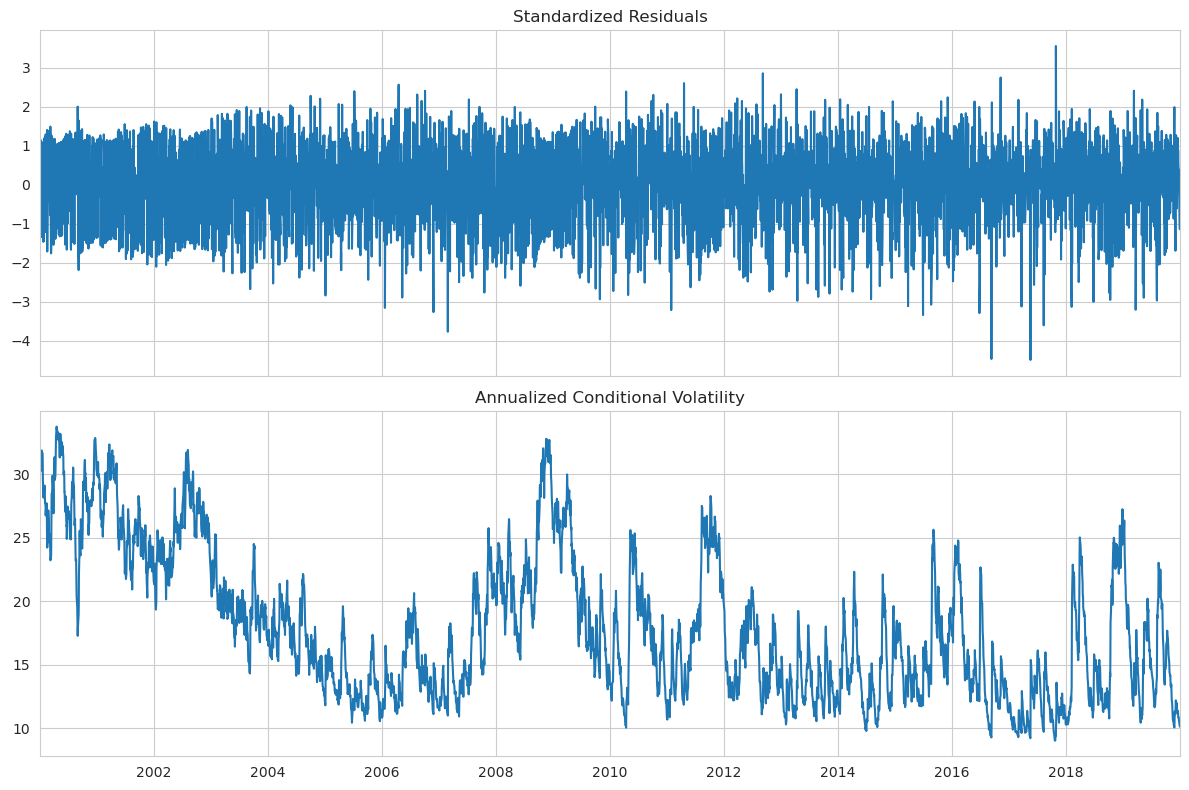

In [15]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

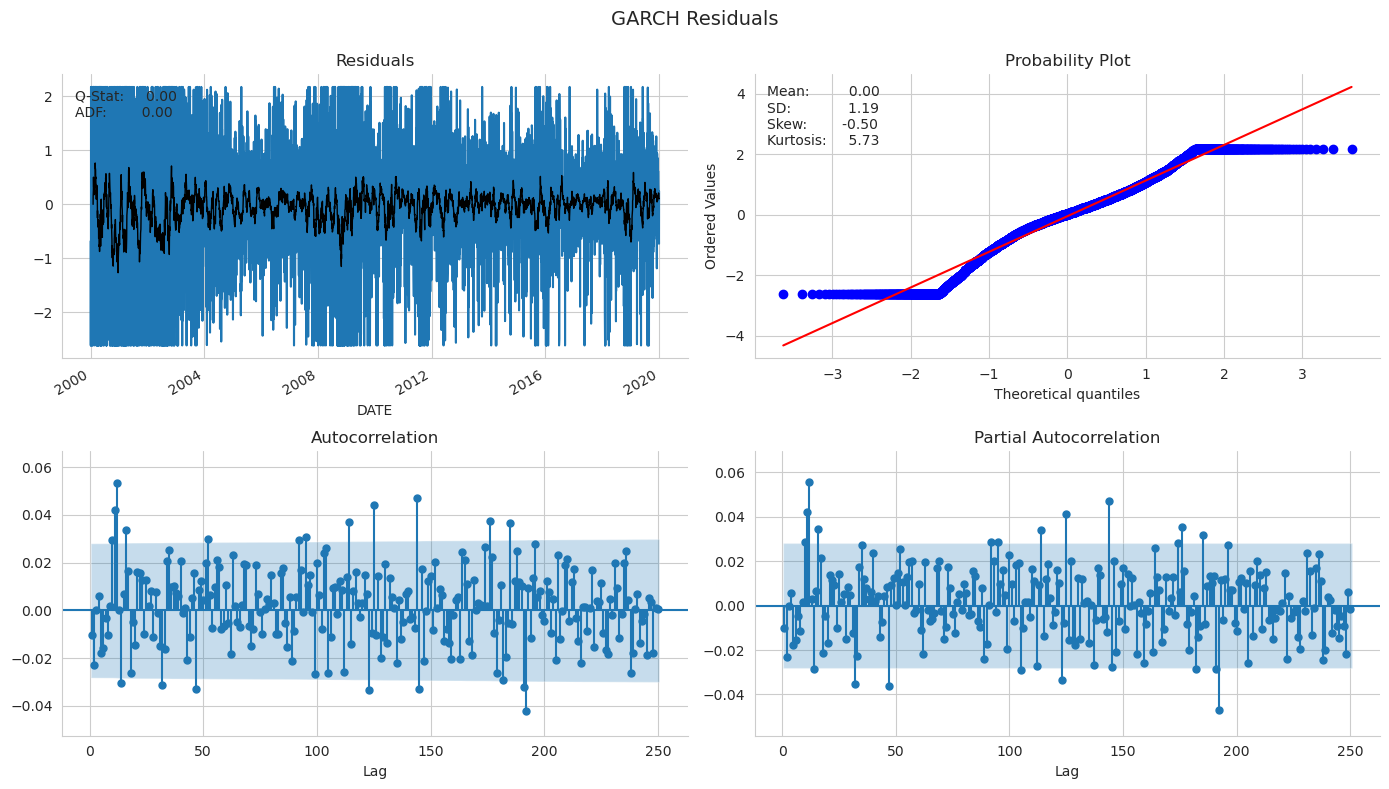

In [16]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')